## parsing RIP.ie data

In [275]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
sns.set_context('talk')
pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
import geopandas as gpd

In [60]:
raw = pd.read_csv('ripie.csv',encoding='Latin-1')
raw = raw.drop_duplicates(subset=['date','name'])
raw['date'] = pd.to_datetime(raw.date,format='%d/%m/%y',errors='coerce')
raw = raw[~raw.date.isnull()]

## parse names

In [61]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
def check_name(x):
    if 'née' in x:
        return 'F'    
    s = x.split(',')[1].strip()
    #handle double names
    s = s.split()
    for n in s:       
        if n.strip("()").lower() in female:            
            return 'F'
    return 'M'
    
raw['sex'] = raw['name'].apply(check_name)
raw.sex.value_counts()

M    23403
F    22618
Name: sex, dtype: int64

## get time fields

In [62]:
raw['year'] = raw.date.dt.year
raw['month'] = raw.date.dt.month
raw['day'] = raw.date.dt.dayofyear

In [63]:
raw[100:200]

,name,town,county,date,sex,year,month,day
132,"WEEKES (née O'FARRELL), BERNADETTE",Ballyfermot,Dublin,2020-12-31,F,2020,12,366
133,"Whelan, Walter (Wattie)",Mullinavat,Kilkenny,2020-12-31,M,2020,12,366
134,"Whelan, Patrick (Pat)",Bansha,Tipperary,2020-12-31,M,2020,12,366
135,"Wickham (née Buckley), Bridget Christina (Chri...",Enniscorthy,Wexford,2020-12-31,F,2020,12,366
136,"Wilson, Anthony",Tinahely,Wicklow,2020-12-31,M,2020,12,366
...,...,...,...,...,...,...,...,...
266,"Wiseman, William (Willie)",Bantry,Cork,2020-12-30,M,2020,12,365
267,"WYLDE (née O'Halloran), Joanne",Foxrock,Dublin,2020-12-30,F,2020,12,365
269,"Ambrose, Brigid (Bridie)",Killester,Dublin,2020-12-29,F,2020,12,364
271,"Arrigan, John (Emmet)",Roscrea,Tipperary,2020-12-29,M,2020,12,364


In [65]:
totals = raw.year.value_counts()
totals

2020    31434
2019    14587
Name: year, dtype: int64

In [66]:
bymonth = pd.pivot_table(raw, index='month',columns='year',values='name',aggfunc='size')

<AxesSubplot:xlabel='month'>

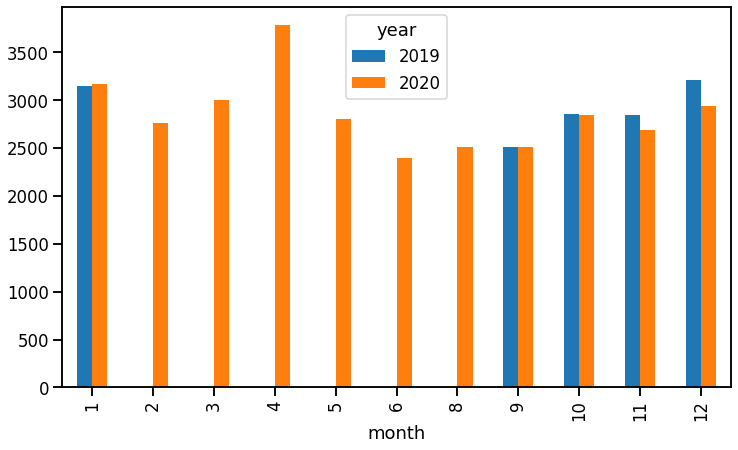

In [67]:
bymonth.plot(kind='bar',figsize=(12,7))

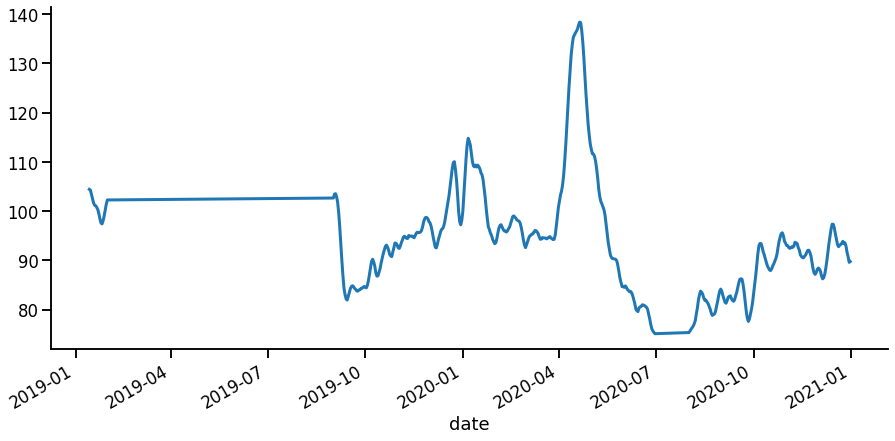

In [234]:
x = raw.groupby('date').size()
x.rolling(14,win_type='hamming').mean().plot(lw=3,figsize=(15,7))
sns.despine()

In [68]:
byday = pd.pivot_table(raw, index='day',columns='year',values='name',aggfunc='size')
byday.to_csv('rip_deaths_daily.csv')

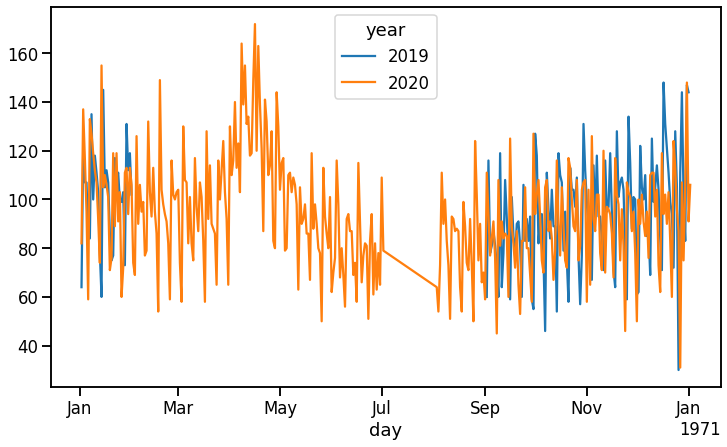

In [99]:
ax=byday.plot(figsize=(12,7))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

In [177]:
meanday = byday.rolling(window=14,win_type='hamming').mean()

<AxesSubplot:xlabel='day'>

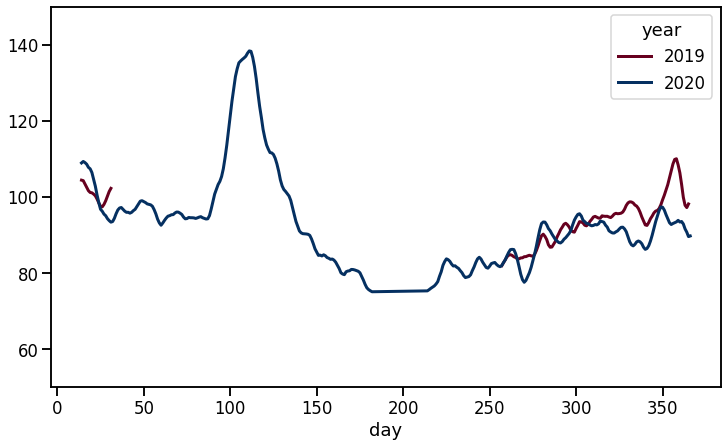

In [178]:
meanday.plot(figsize=(12,7),ylim=(50,150),lw=3,cmap='RdBu')

## aggregate days in long form for seaborn plots

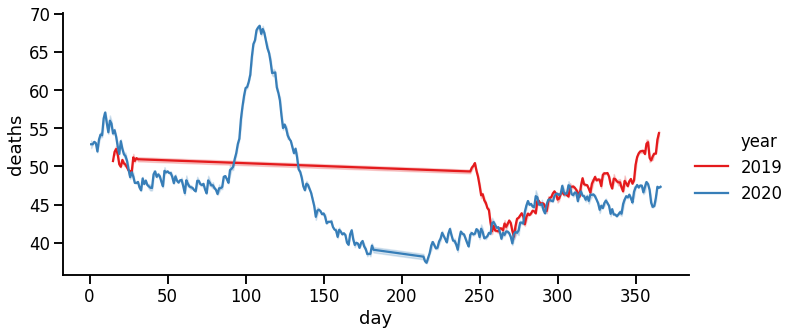

In [162]:
g = raw.groupby(['date','day','year','sex'],as_index=False).size()
g['deaths'] = g['size'].rolling(30).mean(win_type='hamming')
fg=sns.relplot(data=g,x='day',y='deaths',hue='year',kind='line',aspect=2,palette='Set1')

## plot with covid deaths

In [228]:
covd = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={"latestWkid":3857,"wkid":102100}')
covd['date'] = pd.to_datetime(covd['Date'], infer_datetime_format=True)
cols=['date','ConfirmedCovidCases','HospitalisedCovidCases','ConfirmedCovidDeaths']
covd=covd[cols]

In [257]:
covd['day'] = covd.date.dt.dayofyear
covd['year'] = covd.date.dt.year

X = raw.groupby('date').size().reset_index()
X=X.rename(columns={0:'deaths'})
M = X.merge(covd,on='date',how='inner')
M['difference'] = M.deaths - M['ConfirmedCovidDeaths']
M['mean deaths'] = M['deaths'].rolling(14).mean()
M['covid deaths'] = M['ConfirmedCovidDeaths'].rolling(14).mean()

In [263]:
M

,date,deaths,ConfirmedCovidCases,HospitalisedCovidCases,ConfirmedCovidDeaths,day,year,difference,mean deaths,covid deaths
0,2020-02-29,74,1,NaN,0,60,2020,74,NaN,NaN
1,2020-03-03,108,1,NaN,0,63,2020,108,NaN,NaN
2,2020-03-04,107,4,NaN,0,64,2020,107,NaN,NaN
3,2020-03-05,82,7,NaN,0,65,2020,82,NaN,NaN
4,2020-03-06,101,5,NaN,0,66,2020,101,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
269,2020-12-27,75,744,5840.0,4,362,2020,71,91.714286,5.714286
270,2020-12-28,106,765,5873.0,1,363,2020,105,90.785714,5.642857
271,2020-12-29,148,1546,5898.0,9,364,2020,139,94.642857,5.714286
272,2020-12-30,91,1718,5932.0,13,365,2020,78,93.857143,6.214286


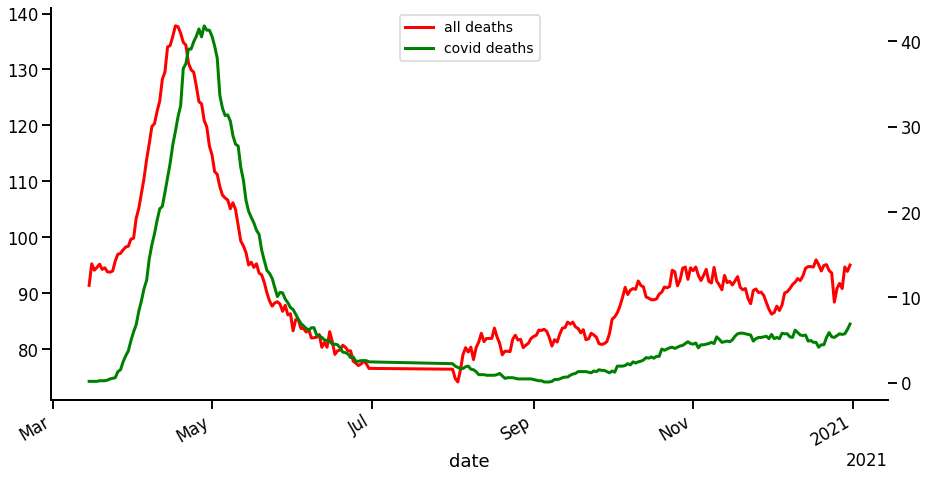

In [276]:
f,ax=plt.subplots(1,1,figsize=(15,8))
ax1=ax.twinx()
M.plot(x='date',y='mean deaths',figsize=(15,8),c='r',lw=3,legend=False,ax=ax)
M.plot(x='date',y='covid deaths',figsize=(15,8),c='g',lw=3,legend=False,ax=ax1)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0]],['all deaths','covid deaths'],loc=9,fontsize=14)
sns.despine()

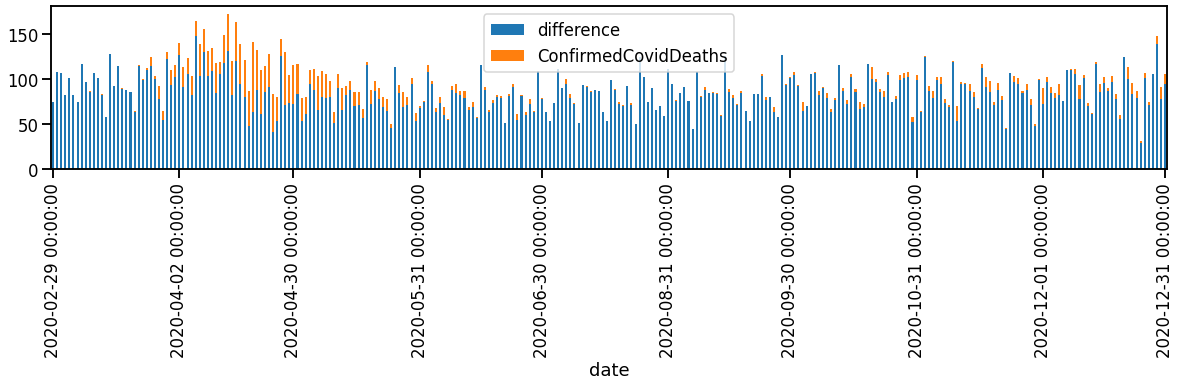

In [282]:
sm = M[M.date>'2020-06-01']
ax=M.plot('date',y=['difference','ConfirmedCovidDeaths'],kind='bar',stacked=True,figsize=(20,3))
ax.xaxis.set_major_locator(locator)
